In [87]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_sch
import visdom
import time
from torchsample.callbacks import EarlyStopping

In [88]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [89]:
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
TITAN Xp
Memory Usage:
Allocated: 0.1 GB
Cached:    0.2 GB


In [90]:
'''Actual Start of Loading MNIST'''

download_root = './MNIST_DATASET'

mnist_transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.1307,), (0.3081,))])

dataset = datasets.MNIST(download_root, train=True, transform = mnist_transform, download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [50000,10000])

test_dataset = datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [91]:
batch_size = 1
val_batch_size=10000
test_batch_size = 10000
epochs = 30
lr = 0.01

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size = val_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = test_batch_size, shuffle = True)

In [92]:
'''Defining NN'''
from torch.nn.init import xavier_uniform_,uniform_


class Net(nn.Module):
    '''fc1_A shows d_p array that accumulates gradient updates
       fc1_c shows actual weight parameter array
       
       At the very first time, parameters of array A for all fc1,2,3
       have to be initialized to zero
       
       And then updtaed gradients will only be accumulated on A
       while leaving C array as it is until k==ns
       
       x: inputs
       '''
    def __init__(self):
        super(Net, self).__init__()
        self.fc1_A = nn.Linear(784, 256)
        self.fc1_A.weight.data.fill_(0)
        self.fc1_A.bias.data.fill_(0)
        self.fc1_C = nn.Linear(784, 256)

        self.fc2_A = nn.Linear(256, 128)
        self.fc2_A.weight.data.fill_(0)
        self.fc2_A.bias.data.fill_(0)
        self.fc2_C = nn.Linear(256, 128)

        self.fc3_A = nn.Linear(128, 10)
        self.fc3_A.weight.data.fill_(0)
        self.fc3_A.bias.data.fill_(0)
        self.fc3_C = nn.Linear(128, 10)
        
        
        
    def forward(self, x):
        gamma=1
        x=x.view(-1,784)
        x=gamma*self.fc1_A(x) + self.fc1_C(x)
        x=F.relu(x)
        x=gamma*self.fc2_A(x) + self.fc2_C(x)
        x=F.relu(x)
        x=gamma*self.fc3_A(x) + self.fc3_C(x)
        
        return x
        
model = Net()
print(model)
model.to(device)

Net(
  (fc1_A): Linear(in_features=784, out_features=256, bias=True)
  (fc1_C): Linear(in_features=784, out_features=256, bias=True)
  (fc2_A): Linear(in_features=256, out_features=128, bias=True)
  (fc2_C): Linear(in_features=256, out_features=128, bias=True)
  (fc3_A): Linear(in_features=128, out_features=10, bias=True)
  (fc3_C): Linear(in_features=128, out_features=10, bias=True)
)


Net(
  (fc1_A): Linear(in_features=784, out_features=256, bias=True)
  (fc1_C): Linear(in_features=784, out_features=256, bias=True)
  (fc2_A): Linear(in_features=256, out_features=128, bias=True)
  (fc2_C): Linear(in_features=256, out_features=128, bias=True)
  (fc3_A): Linear(in_features=128, out_features=10, bias=True)
  (fc3_C): Linear(in_features=128, out_features=10, bias=True)
)

In [93]:
'''Custom Optimizer'''
'''tiki-taka's asymmetric characteristic simulated here'''

from torch.optim.optimizer import Optimizer, required
# import copy
from torch.nn.init import xavier_uniform_, zeros_
# from torch.nn.modules.linear import reset_parameters

class Tiki_Taka(Optimizer, Net):
    """Implements RPU based SGD algorithm
    Parameters:...
    
    """
    
    def __init__(self, params, lr = required, momentum =0, dampening =0, weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay<0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        super(Tiki_Taka, self).__init__(params, defaults)
        self.update_count = 0

    def __setstate__(self, state):
        super(Tiki_Taka, self).__setstate__(state)
        
#     ns=0
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step"""
        
        loss =None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
        
            counter=0
            for p in group['params']:
#                 import pdb;pdb.set_trace()
                if p.grad is None:
                    continue
                
                d_p=p.grad
                
                if counter in [0,1,4,5,8,9]:

                    asym=1+1.66*p
                    asym2=1-1.66*p
                    new=F.relu(torch.sign(d_p), inplace=False)
                    new2=F.relu(-torch.sign(d_p), inplace=False)
                    mul = new.mul(asym)
                    mul2=new2.mul(asym2)

                    p.add_(torch.mul(mul,d_p),alpha=-group['lr']).add_(torch.mul(mul2,d_p),alpha=-group['lr'])
                    
                    counter+=1      
                elif counter in [12,13,14,15]:
                    p.add_(d_p, alpha=-group['lr'])
                    counter+=1
                else:
                    counter+=1
                    continue
#                 import pdb;pdb.set_trace()
        return loss 
    
    
    @torch.no_grad()
    def update(self, closure=None, count=[0]):
        """Performs a second optimization step
        alpha here signifies lambda value in Tiki-Taka"""
        
        loss =None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']


            if self.update_count<256:
                
                asym=group['params'][2][self.update_count]*1.66+1
                asym2=1-1.66*group['params'][2][self.update_count]
                new=F.relu(torch.sign(group['params'][0][self.update_count]), inplace=False)

                new2=F.relu(-torch.sign(group['params'][0][self.update_count]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][2][self.update_count].add_(torch.mul(mul,group['params'][0][self.update_count]), alpha=-0.02).add_(torch.mul(mul2,group['params'][0][self.update_count]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][0][self.update_count])
                self.update_count+=1
                
            
            elif self.update_count==256:
                asym=1+1.66*group['params'][3]
                asym2=1-1.66*group['params'][3]
                new=F.relu(torch.sign(group['params'][1]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][1]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][3].add_(torch.mul(mul,group['params'][1]), alpha=-0.02).add_(torch.mul(mul2,group['params'][1]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][1])

                self.update_count+=1

            elif self.update_count>256 and self.update_count<385:
                asym=1+1.66*group['params'][6][self.update_count-257]
                asym2=1-1.66*group['params'][6][self.update_count-257]
                new=F.relu(torch.sign(group['params'][4][self.update_count-257]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][4][self.update_count-257]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][6][self.update_count-257].add_(torch.mul(mul,group['params'][4][self.update_count-257]), alpha=-0.02).add_(torch.mul(mul2,group['params'][4][self.update_count-257]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][4][self.update_count-257])

                self.update_count+=1
                
            elif self.update_count==385:
                asym=1+1.66*group['params'][7]
                asym2=1-1.66*group['params'][7]
                new=F.relu(torch.sign(group['params'][5]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][5]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][7].add_(torch.mul(mul,group['params'][5]), alpha=-0.02).add_(torch.mul(mul2,group['params'][5]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][5])

                self.update_count+=1

            elif self.update_count>385 and self.update_count<396:
                asym=1+1.66*group['params'][10][self.update_count-386]
                asym2=1-1.66*group['params'][10][self.update_count-386]
                new=F.relu(torch.sign(group['params'][8][self.update_count-386]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][8][self.update_count-386]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][10][self.update_count-386].add_(torch.mul(mul,group['params'][8][self.update_count-386]), alpha=-0.02).add_(torch.mul(mul2,group['params'][8][self.update_count-386]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][8][self.update_count-386])

                self.update_count+=1
                
            elif self.update_count==396:
                asym=1+1.66*group['params'][11]
                asym2=1-1.66*group['params'][11]
                new=F.relu(torch.sign(group['params'][9]), inplace=False)
                new2=F.relu(-torch.sign(group['params'][9]), inplace=False)
                mul = new.mul(asym)
                mul2=new2.mul(asym2)

                group['params'][11].add_(torch.mul(mul,group['params'][9]), alpha=-0.02).add_(torch.mul(mul2,group['params'][9]), alpha=-0.02)
#                 nn.init.zeros_(group['params'][9])               
                self.update_count=0
    
            else:
                assert False, "Don't go here"

In [94]:
'''Loss function and Optimizer'''

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = Tiki_Taka(model.parameters(), lr=learning_rate)


In [95]:
def train_model(model, batch_size, patience, n_epochs):
    model.to(device)
    # to track the training loss as the model trains
    train_losses = []
    train_accuracies=[]
    # to track the validation loss as the model trains
    valid_losses = []
    valid_accuracies=[]
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    avg_train_accuracies=[]
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    avg_valid_accuracies=[]
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scheduler = lr_sch.MultiStepLR(optimizer, milestones=[1,3,5,7,9],gamma=0.7)

    for epoch in range(1, n_epochs + 1):
        ns=0
        correct=0
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, data in enumerate(train_loader, 1):
            inputs,target = data[0].to(device), data[1].to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            if ns%100==99:
#         if ns>0:
                optimizer.update()
            # record training loss
            train_losses.append(loss.item())
#             print(train_losses)
#             print(type(train_losses))
            pred=output.data.max(1,keepdim=True)[1]
            correct=sum(pred.eq(target.data.view_as(pred)))*100.
            train_accuracies.append(correct.item())
#             print(correct)
#             print(correct.item())
            ns+=1
            
            if batch%1000==0:
                train_loss=sum(train_losses[batch-1000:batch])/1000.
                train_acc=sum(train_accuracies[batch-1000:batch])/1000.
                print_inter=(f'epoch:{epoch}/{epochs} ' +
                      f'step:{batch}/{len(train_loader)} ' +
                      f'loss:{train_loss:.4f} '
                      f'accuracy:{train_acc:.4f}'
                     )
                print(print_inter)
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data in valid_loader:
            inputs,target = data[0].to(device), data[1].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())
            pred=output.data.max(1,keepdim=True)[1]
            correct=sum(pred.eq(target.data.view_as(pred)))*100./len(valid_loader.dataset)
            valid_accuracies.append(correct.item())
#             import pdb;pdb.set_trace()

        scheduler.step()
        print(f"lr:{optimizer.param_groups[0]['lr']}")
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        train_accuracy=np.average(train_accuracies)
        valid_loss = np.average(valid_losses)
        valid_accuracy=np.average(valid_accuracies)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_train_accuracies.append(train_accuracy)
        avg_valid_accuracies.append(valid_accuracy)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}'+
                    f'train_accuracy:{train_accuracy:.5f}'+
                    f'valid_accuracy:{valid_accuracy:.5f}')
        
        print(print_msg)
#         import pdb;pdb.set_trace()

        # clear lists to track next epoch
        train_losses = []
        train_accuracies=[]
        valid_losses = []
        valid_accuracies=[]
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses, avg_train_accuracies, avg_valid_accuracies

In [96]:
model.to(device)

batch_size = 1
n_epochs = 30

train_loader, test_loader, valid_loader 

# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

model, train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, batch_size, patience, n_epochs)

epoch:1/30 step:1000/50000 loss:1.0888 accuracy:65.0000
epoch:1/30 step:2000/50000 loss:0.5324 accuracy:82.8000
epoch:1/30 step:3000/50000 loss:0.4143 accuracy:88.3000
epoch:1/30 step:4000/50000 loss:0.4830 accuracy:85.8000
epoch:1/30 step:5000/50000 loss:0.3918 accuracy:87.6000
epoch:1/30 step:6000/50000 loss:0.3401 accuracy:89.0000
epoch:1/30 step:7000/50000 loss:0.3205 accuracy:89.9000
epoch:1/30 step:8000/50000 loss:0.3127 accuracy:90.2000
epoch:1/30 step:9000/50000 loss:0.2929 accuracy:90.9000
epoch:1/30 step:10000/50000 loss:0.2806 accuracy:90.9000
epoch:1/30 step:11000/50000 loss:0.2811 accuracy:90.6000
epoch:1/30 step:12000/50000 loss:0.2862 accuracy:91.8000
epoch:1/30 step:13000/50000 loss:0.2977 accuracy:89.8000
epoch:1/30 step:14000/50000 loss:0.2442 accuracy:92.4000
epoch:1/30 step:15000/50000 loss:0.2666 accuracy:91.1000
epoch:1/30 step:16000/50000 loss:0.1867 accuracy:95.1000
epoch:1/30 step:17000/50000 loss:0.2462 accuracy:91.7000
epoch:1/30 step:18000/50000 loss:0.2360 

epoch:3/30 step:39000/50000 loss:0.1533 accuracy:95.4000
epoch:3/30 step:40000/50000 loss:0.1495 accuracy:95.1000
epoch:3/30 step:41000/50000 loss:0.1477 accuracy:95.4000
epoch:3/30 step:42000/50000 loss:0.1583 accuracy:95.1000
epoch:3/30 step:43000/50000 loss:0.1493 accuracy:95.3000
epoch:3/30 step:44000/50000 loss:0.1266 accuracy:95.8000
epoch:3/30 step:45000/50000 loss:0.1685 accuracy:94.1000
epoch:3/30 step:46000/50000 loss:0.1290 accuracy:95.8000
epoch:3/30 step:47000/50000 loss:0.1364 accuracy:96.1000
epoch:3/30 step:48000/50000 loss:0.1926 accuracy:93.5000
epoch:3/30 step:49000/50000 loss:0.1431 accuracy:95.8000
epoch:3/30 step:50000/50000 loss:0.1354 accuracy:95.5000
lr:0.004899999999999999
[ 3/30] train_loss: 0.14043 valid_loss: 0.18983train_accuracy:95.63200valid_accuracy:94.11000
EarlyStopping counter: 1 out of 10
epoch:4/30 step:1000/50000 loss:0.1265 accuracy:95.9000
epoch:4/30 step:2000/50000 loss:0.0956 accuracy:97.2000
epoch:4/30 step:3000/50000 loss:0.1115 accuracy:96.

epoch:6/30 step:25000/50000 loss:0.1198 accuracy:96.2000
epoch:6/30 step:26000/50000 loss:0.0958 accuracy:97.6000
epoch:6/30 step:27000/50000 loss:0.0927 accuracy:97.3000
epoch:6/30 step:28000/50000 loss:0.0983 accuracy:97.3000
epoch:6/30 step:29000/50000 loss:0.1365 accuracy:95.8000
epoch:6/30 step:30000/50000 loss:0.0754 accuracy:97.8000
epoch:6/30 step:31000/50000 loss:0.1065 accuracy:97.5000
epoch:6/30 step:32000/50000 loss:0.1048 accuracy:96.9000
epoch:6/30 step:33000/50000 loss:0.0971 accuracy:96.9000
epoch:6/30 step:34000/50000 loss:0.0978 accuracy:97.2000
epoch:6/30 step:35000/50000 loss:0.1182 accuracy:96.3000
epoch:6/30 step:36000/50000 loss:0.1121 accuracy:96.6000
epoch:6/30 step:37000/50000 loss:0.1125 accuracy:96.8000
epoch:6/30 step:38000/50000 loss:0.0888 accuracy:97.2000
epoch:6/30 step:39000/50000 loss:0.0746 accuracy:98.0000
epoch:6/30 step:40000/50000 loss:0.0704 accuracy:98.3000
epoch:6/30 step:41000/50000 loss:0.0931 accuracy:97.3000
epoch:6/30 step:42000/50000 los

epoch:9/30 step:10000/50000 loss:0.0906 accuracy:97.7000
epoch:9/30 step:11000/50000 loss:0.1047 accuracy:96.9000
epoch:9/30 step:12000/50000 loss:0.0834 accuracy:98.0000
epoch:9/30 step:13000/50000 loss:0.0676 accuracy:98.3000
epoch:9/30 step:14000/50000 loss:0.0955 accuracy:98.1000
epoch:9/30 step:15000/50000 loss:0.1036 accuracy:97.0000
epoch:9/30 step:16000/50000 loss:0.0965 accuracy:97.7000
epoch:9/30 step:17000/50000 loss:0.1003 accuracy:97.0000
epoch:9/30 step:18000/50000 loss:0.0727 accuracy:98.4000
epoch:9/30 step:19000/50000 loss:0.1062 accuracy:97.1000
epoch:9/30 step:20000/50000 loss:0.0850 accuracy:97.8000
epoch:9/30 step:21000/50000 loss:0.0979 accuracy:97.0000
epoch:9/30 step:22000/50000 loss:0.1156 accuracy:96.7000
epoch:9/30 step:23000/50000 loss:0.1114 accuracy:96.7000
epoch:9/30 step:24000/50000 loss:0.1142 accuracy:96.1000
epoch:9/30 step:25000/50000 loss:0.0967 accuracy:97.3000
epoch:9/30 step:26000/50000 loss:0.0927 accuracy:97.7000
epoch:9/30 step:27000/50000 los

epoch:11/30 step:47000/50000 loss:0.1059 accuracy:97.1000
epoch:11/30 step:48000/50000 loss:0.0829 accuracy:98.0000
epoch:11/30 step:49000/50000 loss:0.0876 accuracy:97.8000
epoch:11/30 step:50000/50000 loss:0.1088 accuracy:97.1000
lr:0.0016806999999999992
[11/30] train_loss: 0.09559 valid_loss: 0.12035train_accuracy:97.59400valid_accuracy:96.80000
EarlyStopping counter: 1 out of 10
epoch:12/30 step:1000/50000 loss:0.0884 accuracy:98.2000
epoch:12/30 step:2000/50000 loss:0.1050 accuracy:97.8000
epoch:12/30 step:3000/50000 loss:0.1027 accuracy:97.5000
epoch:12/30 step:4000/50000 loss:0.0993 accuracy:97.7000
epoch:12/30 step:5000/50000 loss:0.1095 accuracy:97.0000
epoch:12/30 step:6000/50000 loss:0.0792 accuracy:98.2000
epoch:12/30 step:7000/50000 loss:0.0971 accuracy:97.5000
epoch:12/30 step:8000/50000 loss:0.0860 accuracy:97.8000
epoch:12/30 step:9000/50000 loss:0.0939 accuracy:97.5000
epoch:12/30 step:10000/50000 loss:0.0901 accuracy:97.7000
epoch:12/30 step:11000/50000 loss:0.0867 ac

epoch:14/30 step:31000/50000 loss:0.1046 accuracy:97.8000
epoch:14/30 step:32000/50000 loss:0.1164 accuracy:97.0000
epoch:14/30 step:33000/50000 loss:0.1334 accuracy:96.6000
epoch:14/30 step:34000/50000 loss:0.1051 accuracy:97.8000
epoch:14/30 step:35000/50000 loss:0.1158 accuracy:97.3000
epoch:14/30 step:36000/50000 loss:0.1191 accuracy:96.4000
epoch:14/30 step:37000/50000 loss:0.1077 accuracy:97.0000
epoch:14/30 step:38000/50000 loss:0.1313 accuracy:96.8000
epoch:14/30 step:39000/50000 loss:0.1090 accuracy:97.2000
epoch:14/30 step:40000/50000 loss:0.1168 accuracy:97.1000
epoch:14/30 step:41000/50000 loss:0.1304 accuracy:96.6000
epoch:14/30 step:42000/50000 loss:0.1134 accuracy:97.5000
epoch:14/30 step:43000/50000 loss:0.1068 accuracy:97.2000
epoch:14/30 step:44000/50000 loss:0.0920 accuracy:97.6000
epoch:14/30 step:45000/50000 loss:0.1221 accuracy:96.7000
epoch:14/30 step:46000/50000 loss:0.1189 accuracy:97.1000
epoch:14/30 step:47000/50000 loss:0.1189 accuracy:96.8000
epoch:14/30 st

epoch:17/30 step:15000/50000 loss:0.1275 accuracy:96.7000
epoch:17/30 step:16000/50000 loss:0.1333 accuracy:96.3000
epoch:17/30 step:17000/50000 loss:0.1369 accuracy:96.4000
epoch:17/30 step:18000/50000 loss:0.1123 accuracy:96.9000
epoch:17/30 step:19000/50000 loss:0.1399 accuracy:96.4000
epoch:17/30 step:20000/50000 loss:0.1038 accuracy:97.4000
epoch:17/30 step:21000/50000 loss:0.1152 accuracy:96.7000
epoch:17/30 step:22000/50000 loss:0.1088 accuracy:96.8000
epoch:17/30 step:23000/50000 loss:0.1402 accuracy:96.6000
epoch:17/30 step:24000/50000 loss:0.1249 accuracy:96.7000
epoch:17/30 step:25000/50000 loss:0.1381 accuracy:96.4000
epoch:17/30 step:26000/50000 loss:0.1331 accuracy:96.0000
epoch:17/30 step:27000/50000 loss:0.1344 accuracy:95.8000
epoch:17/30 step:28000/50000 loss:0.1427 accuracy:97.0000
epoch:17/30 step:29000/50000 loss:0.1209 accuracy:97.2000
epoch:17/30 step:30000/50000 loss:0.1321 accuracy:96.6000
epoch:17/30 step:31000/50000 loss:0.1229 accuracy:96.7000
epoch:17/30 st

epoch:20/30 step:1000/50000 loss:0.1514 accuracy:96.6000
epoch:20/30 step:2000/50000 loss:0.1394 accuracy:96.8000
epoch:20/30 step:3000/50000 loss:0.1384 accuracy:97.1000
epoch:20/30 step:4000/50000 loss:0.1453 accuracy:96.3000
epoch:20/30 step:5000/50000 loss:0.1388 accuracy:96.6000
epoch:20/30 step:6000/50000 loss:0.1230 accuracy:96.4000
epoch:20/30 step:7000/50000 loss:0.1253 accuracy:96.7000
epoch:20/30 step:8000/50000 loss:0.1113 accuracy:97.0000
epoch:20/30 step:9000/50000 loss:0.1388 accuracy:96.0000
epoch:20/30 step:10000/50000 loss:0.1559 accuracy:95.7000
epoch:20/30 step:11000/50000 loss:0.1597 accuracy:95.9000
epoch:20/30 step:12000/50000 loss:0.1304 accuracy:97.0000
epoch:20/30 step:13000/50000 loss:0.1418 accuracy:97.0000
epoch:20/30 step:14000/50000 loss:0.1531 accuracy:96.1000
epoch:20/30 step:15000/50000 loss:0.1429 accuracy:95.9000
epoch:20/30 step:16000/50000 loss:0.1566 accuracy:96.4000
epoch:20/30 step:17000/50000 loss:0.1324 accuracy:96.4000
epoch:20/30 step:18000/

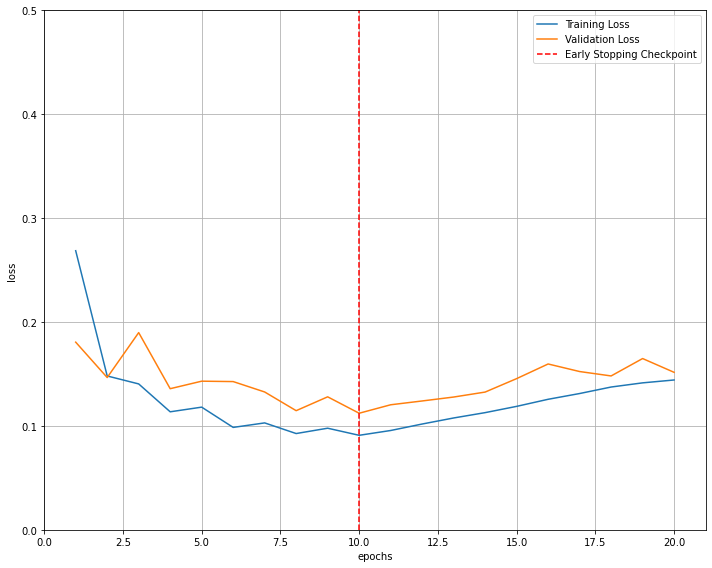

In [97]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')


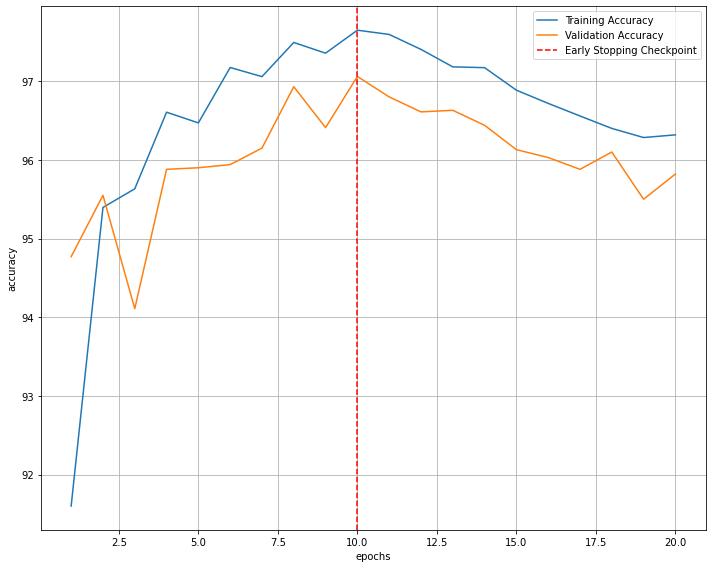

In [98]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(valid_accuracy)+1),valid_accuracy,label='Validation Accuracy')

# find position of lowest validation loss
maxposs = valid_accuracy.index(max(valid_accuracy))+1 
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.ylim(0, 0.5) # consistent scale
# plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches='tight')


In [99]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.to(device)
model.eval() # prep model for evaluation
# import pdb;pdb.set_trace()
for data in test_loader:
    inputs,target = data[0].to(device), data[1].to(device)
    
    if len(target.data) != test_batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(inputs)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*inputs.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(test_batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
# import pdb;pdb.set_trace()

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100. * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
# import pdb;pdb.set_trace()

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
# import pdb;pdb.set_trace()


Test Loss: 0.099899

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 98% (1121/1135)
Test Accuracy of     2: 95% (990/1032)
Test Accuracy of     3: 96% (977/1010)
Test Accuracy of     4: 96% (948/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 97% (1003/1028)
Test Accuracy of     8: 96% (943/974)
Test Accuracy of     9: 96% (975/1009)

Test Accuracy (Overall): 97% (9727/10000)
